**Python**:
- Что пошло не так с кампанией:
В среднем ARPU был ниже чем стоимость привлечения юзера
В среднем ARPPU был всего лишь на 100% больше чем стоимость привлечения нового юзера
- Реклама не окупалась
- Была выбрана не та целевая аудитория: по сути платить готовы были только "новые" юзеры и в среднем совершали одну покупку. После прекращения рекламы и транзакции и без того небольшого размера постепенно сошли на нет.
Как фиксить:
- полностью перерабатывать кампанию/ии
- растить LTV

**SQL**:

В данных есть шумы и "незаконченные" или "неначатые" сессии - то есть, юзеры у которых указаны только время начала сессий или только время конца, так же присутствуют шумы - технические сессии юзеров, длительностью 1-2 секунды
Решение:
- Делаем оконную функцию "LEAD" по юзерам - получаем в строке для каждого старта сессии - время его конца (следующую строку).
- Фильтруем юзеров по условию "строка содержит и  session_start и seesion_end" - таком образом, отсеиваем юзеров у которых есть только session_start или seesion_end значения. Сортируем сессии по длинне - находим технические сессии - фильтруем по сессии по длинне >2 sec.
- Считаем среднюю длинну сессии на очищенных данных.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import sqlite3

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# SQL

Средствами SQL необходимо рассчитать среднюю длину сессий пользователей.

```
WITH temp AS (
-- replace session starts/finish to 1/0
-- get the end date for each session timestamp
SELECT s. user_id, 
CASE WHEN s. event = 'start' THEN 1 ELSE 0 END is_sess_starts,
s.ts,
LEAD(s.ts) OVER (PARTITION BY s.user_id ORDER BY s.ts) sess_ends
FROM "sessions3" s),

sess_duration AS (
SELECT *,
JULIANDAY(sess_ends) - JULIANDAY(ts) sess_duration
FROM temp
WHERE is_sess_starts = 1),

avg_sess_dur_per_user AS (
-- avg session duration for each user
SELECT user_id ,
ROUND(AVG(sess_duration) * 24 * 60, 2) avg_sess_dur_in_min
FROM sess_duration
GROUP BY user_id
ORDER BY avg_sess_dur_in_min DESC)

-- avg session duration for all users
SELECT AVG(sess_duration) * 24 * 60 avg_sess_dur_in_min
FROM sess_duration
WHERE user_id != 1001 AND user_id != 1003
```

Need to mention that for some users, for example `user_id=1002`, there are only `end` sessions in the `event` column.

It easy to exclude users with `end` label only (by using `WHERE is_sess_starts = 1` condition), that have strings only with `end` or `0` in the `event` column. But it's harder to exclude users who have only the `start` label.

But as I can see, there are no a lot of "bad" users. For counting **the average session duration per user** it's not neccessary to exclude them. It's also could be helpful to check them deeper and find the reason of this error. But for counting **the average session duration for all users** would be better to exclude them.

# Pandas

### Task

Given some data on marketing campaign, do an exploratory data analysis and build a reproducible report (R markdown/shiny application, python notebook, or any other ways to explore and visualize data). This report should contain:
* Plots of all metrics that can be useful for taking business decisions or have some valuable insights.
* Explanations of why you think this metrics are useful and analysis of them. All thoughts that you have concerning this campaign.
* Final results: what went wrong, what was good, what steps should be considered in the future, maybe what additional information should be added in the future to make analysis better. Also add your thoughts, whether this campaign should be stopped, or it should be continued.

We have data files with following structure:

`Users.csv`:
* `Id` – id of new account;
* `Dt` – date of user registration;

`Spends.csv`:
* `Dt` – date of spends allocation (spends can come from cost of impressions or some other actions);
* `Spends` – amount of spends in USD;

`Logins.csv`:
* `Login_dt` – date of login;
* `Id` – account id (the same as in users.csv);

`Revenue.csv`:
* `Pay_dt` – date of payment;
* `Id` – account id (the same as in users.csv);
* `Revenue` – amount of payment of corresponding user at this day;
* `Currency` – payment currency.

### Data prep

In [4]:
# change the file path if necessary
logins = pd.read_csv('/Users/egoshin/Downloads/TZ_analyst/DMT_task2/logins.csv')

In [5]:
revenue = pd.read_csv('/Users/egoshin/Downloads/TZ_analyst/DMT_task2/revenue.csv')

In [6]:
users = pd.read_csv('/Users/egoshin/Downloads/TZ_analyst/DMT_task2/users.csv')

In [7]:
spends = pd.read_csv('/Users/egoshin/Downloads/TZ_analyst/DMT_task2/spends.csv')

In [8]:
logins.head()

,login_dt,id
0,2018-01-01,1
1,2018-01-01,2
2,2018-01-01,3
3,2018-01-01,4
4,2018-01-01,5


In [9]:
logins.shape

(3184799, 2)

In [10]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3184799 entries, 0 to 3184798
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   login_dt  object
 1   id        int64 
dtypes: int64(1), object(1)
memory usage: 48.6+ MB


In [11]:
logins.isna().mean()

login_dt    0.0
id          0.0
dtype: float64

In [12]:
revenue.head()

,pay_dt,id,revenue,currency
0,2018-01-01,186,64.910968,RUB
1,2018-01-01,393,1.070690,USD
2,2018-01-02,305,0.249002,EUR
3,2018-01-02,358,0.314238,USD
4,2018-01-02,2256,0.555161,USD


In [13]:
revenue.shape

(4052, 4)

In [14]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4052 entries, 0 to 4051
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pay_dt    4052 non-null   object 
 1   id        4052 non-null   int64  
 2   revenue   4052 non-null   float64
 3   currency  4052 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 126.8+ KB


In [15]:
revenue.isna().mean()

pay_dt      0.0
id          0.0
revenue     0.0
currency    0.0
dtype: float64

In [16]:
users.head()

,dt,id
0,2018-01-01,1
1,2018-01-01,2
2,2018-01-01,3
3,2018-01-01,4
4,2018-01-01,5


In [17]:
users.shape

(161435, 2)

In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161435 entries, 0 to 161434
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   dt      161435 non-null  object
 1   id      161435 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


In [19]:
users.isna().mean()

dt    0.0
id    0.0
dtype: float64

In [20]:
spends.head()

,dt,spends_usd
0,2018-01-01,1687.170085
1,2018-01-02,1752.709034
2,2018-01-03,2081.399414
3,2018-01-04,1862.847898
4,2018-01-05,1920.828185


In [21]:
spends.shape

(90, 2)

In [22]:
spends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dt          90 non-null     object 
 1   spends_usd  90 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [23]:
spends.isna().mean()

dt            0.0
spends_usd    0.0
dtype: float64

In [24]:
spends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dt          90 non-null     object 
 1   spends_usd  90 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [25]:
# date to datetime
logins['login_dt'] = pd.to_datetime(logins['login_dt'], format='%Y-%m-%d')
revenue['pay_dt'] = pd.to_datetime(revenue['pay_dt'], format='%Y-%m-%d')
users['dt'] = pd.to_datetime(users['dt'], format='%Y-%m-%d')
spends['dt'] = pd.to_datetime(spends['dt'], format='%Y-%m-%d')

### 1. Users

In [26]:
# No dubles in the users table
len(users) == len(users['id'].unique())

True

In [27]:
print(users['dt'].min(), users['dt'].max(), sep='\n')

2018-01-01 00:00:00
2018-03-31 00:00:00


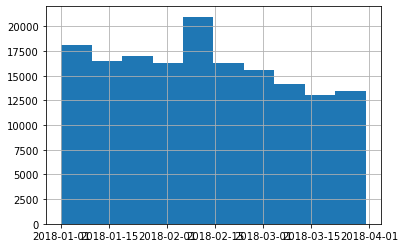

In [28]:
users['dt'].hist();

### 2. Logins

In [29]:
logins.head()

,login_dt,id
0,2018-01-01,1
1,2018-01-01,2
2,2018-01-01,3
3,2018-01-01,4
4,2018-01-01,5


In [30]:
print(logins['login_dt'].min(), logins['login_dt'].max(), sep='\n')

2018-01-01 00:00:00
2018-06-29 00:00:00


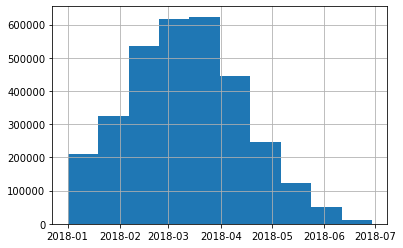

In [31]:
logins['login_dt'].hist();

In [32]:
# users with lots of registrations - looks strange
logins['id'].value_counts()

102554    40
130669    38
20697     38
81695     38
70468     37
          ..
40326      1
41551      1
33358      1
40931      1
32554      1
Name: id, Length: 161435, dtype: int64

### 3. Revenue

In [33]:
print(revenue['pay_dt'].min(), revenue['pay_dt'].max(), sep='\n')

2018-01-01 00:00:00
2018-06-26 00:00:00


In [34]:
revenue['pay_month'] = revenue['pay_dt'].dt.month

In [35]:
revenue.head()

,pay_dt,id,revenue,currency,pay_month
0,2018-01-01,186,64.910968,RUB,1
1,2018-01-01,393,1.070690,USD,1
2,2018-01-02,305,0.249002,EUR,1
3,2018-01-02,358,0.314238,USD,1
4,2018-01-02,2256,0.555161,USD,1


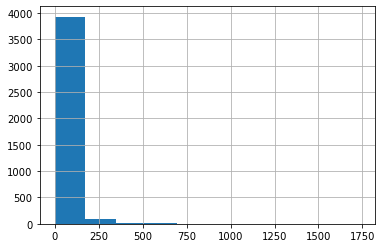

In [36]:
revenue['revenue'].hist();

In [37]:
revenue.groupby('pay_month')['revenue'].agg({'sum', 'count', 'mean', 'median'})

,count,median,mean,sum
pay_month,,,,
1,662,1.395536,17.344072,11481.775390
2,1044,1.376848,19.507920,20366.268628
3,1335,1.384963,27.540351,36766.368954
4,755,1.165449,23.141449,17471.794098
5,226,1.196274,21.096121,4767.723384
6,30,1.568015,14.584510,437.535306


In [38]:
r = revenue.groupby('pay_dt')['revenue'].agg({'sum', 'count', 'mean', 'median'})

In [39]:
r

,count,median,mean,sum
pay_dt,,,,
2018-01-01,2,32.990829,32.990829,65.981658
2018-01-02,6,0.550709,0.905672,5.434031
2018-01-03,9,1.493682,64.166250,577.496253
2018-01-04,8,0.978642,19.009513,152.076106
2018-01-05,7,10.918723,18.655423,130.587963
...,...,...,...,...
2018-06-15,1,4.101767,4.101767,4.101767
2018-06-18,2,16.071752,16.071752,32.143505
2018-06-20,2,0.686383,0.686383,1.372765


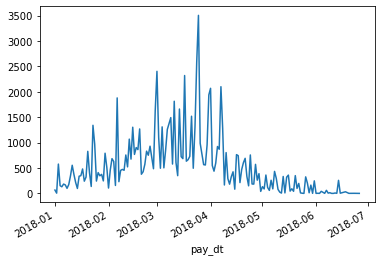

In [40]:
r['sum'].plot();

#### Different currencies

It looks like that it doesn't make a lot of sense to do reporting by different currencies without exchanging them to the single one. Because the same users have payments in different currencies in two days, because the RUB values may confuse in value/real revenue in USD way due to the real USD/RUB echange rate, etc. 

But I will do it in two ways: with and without exchanging.

In [41]:
t = revenue.groupby('currency')['revenue'].agg({'sum', 'count', 'mean', 'median'})

In [42]:
t

,count,median,mean,sum
currency,,,,
EUR,1192,0.804366,1.427496,1701.574807
RUB,863,58.352472,99.902995,86216.284741
USD,1997,1.022201,1.689337,3373.606214


In [43]:
revenue

,pay_dt,id,revenue,currency,pay_month
0,2018-01-01,186,64.910968,RUB,1
1,2018-01-01,393,1.070690,USD,1
2,2018-01-02,305,0.249002,EUR,1
3,2018-01-02,358,0.314238,USD,1
4,2018-01-02,2256,0.555161,USD,1
...,...,...,...,...,...
4047,2018-06-20,149309,0.656961,USD,6
4048,2018-06-20,153857,0.715804,EUR,6
4049,2018-06-23,155881,1.789419,USD,6
4050,2018-06-23,157399,0.385221,EUR,6


In [44]:
r = revenue.groupby(['pay_month', 'currency'])[['revenue']].agg({'sum', 'count', 'mean'}).reset_index()

In [45]:
r

pay_month currency revenue                          
                        count        mean           sum
0          1      EUR     212    1.473344    312.348891
1          1      RUB     123   86.221462  10605.239836
2          1      USD     327    1.725341    564.186664
3          2      EUR     304    1.427443    433.942737
4          2      RUB     229   83.084287  19026.301757
5          2      USD     511    1.773041    906.024134
6          3      EUR     399    1.422468    567.564726
7          3      RUB     296  118.745044  35148.533121
8          3      USD     640    1.641049   1050.271107
9          4      EUR     202    1.412268    285.278112
10         4      RUB     158  105.004647  16590.734165
11         4      USD     395    1.508308    595.781821
12         5      EUR      68    1.345494     91.493604
13         5      RUB      52   85.532002   4447.664092
14         5      USD     106    2.156280    228.565688
15         6      EUR       7    1.563819     10.946736
16         6      RUB       5   79.562354    397.811770
17         6      USD      18    1.598711     28.776800

In [46]:
r = revenue.groupby(['pay_month', 'currency'])['revenue'].agg({'sum', 'count', 'mean'}).reset_index()

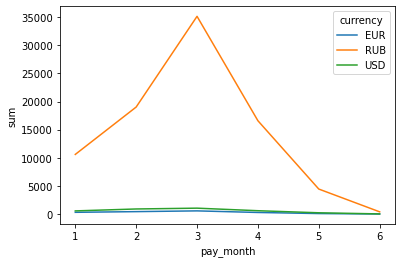

In [47]:
# sum of transactions/month
sns.lineplot(data=r, 
            x='pay_month',
            y='sum',
            hue='currency');

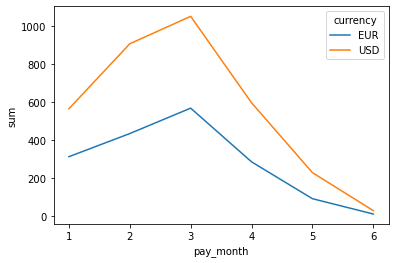

In [48]:
# sum of transactions only for EUR and USD/month
sns.lineplot(data=r[(r['currency']=='EUR') | (r['currency']=='USD')], 
            x='pay_month',
            y='sum',
            hue='currency');

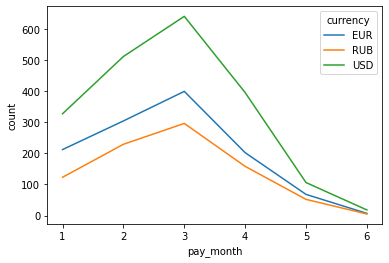

In [49]:
# number of transactions/month
sns.lineplot(data=r, 
            x='pay_month',
            y='count',
            hue='currency');

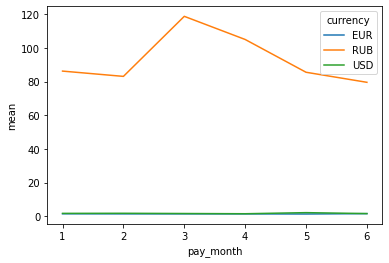

In [50]:
# mean revenue changing/month
sns.lineplot(data=r, 
            x='pay_month',
            y='mean',
            hue='currency');

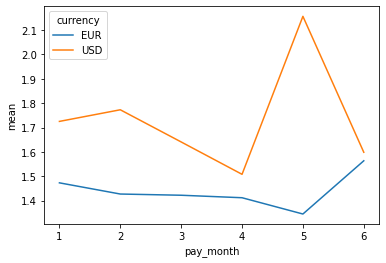

In [51]:
# mean revenue changing only for EUR and USD/month
sns.lineplot(data=r[(r['currency']=='EUR') | (r['currency']=='USD')], 
            x='pay_month',
            y='mean',
            hue='currency');

In [52]:
# user payments/month in different currencies
p = revenue.groupby(['pay_month', 'currency'])['id'].agg('count').reset_index()

In [53]:
p

,pay_month,currency,id
0,1,EUR,212
1,1,RUB,123
2,1,USD,327
3,2,EUR,304
4,2,RUB,229
5,2,USD,511
6,3,EUR,399
7,3,RUB,296
8,3,USD,640
9,4,EUR,202


As we can see further the same user can pay in the different currencies.

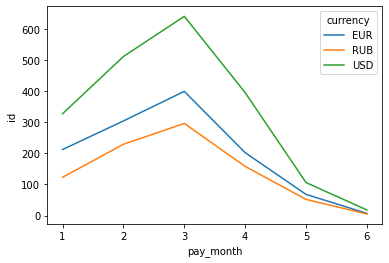

In [54]:
# number of paying users/month
sns.lineplot(data=p, 
            x='pay_month',
            y='id', 
            hue='currency');

In [55]:
r = revenue.groupby('id')['revenue'].agg({'sum', 'count'}).sort_values(['count'], ascending=False)

In [56]:
r.head()

,count,sum
id,,
11372,4,439.508903
66815,4,5.899996
45875,4,21.960447
53625,4,84.121348
49519,4,3.101208


In [57]:
# mean number of transactions/user
r['count'].mean()

1.2634861241035236

In [58]:
revenue

,pay_dt,id,revenue,currency,pay_month
0,2018-01-01,186,64.910968,RUB,1
1,2018-01-01,393,1.070690,USD,1
2,2018-01-02,305,0.249002,EUR,1
3,2018-01-02,358,0.314238,USD,1
4,2018-01-02,2256,0.555161,USD,1
...,...,...,...,...,...
4047,2018-06-20,149309,0.656961,USD,6
4048,2018-06-20,153857,0.715804,EUR,6
4049,2018-06-23,155881,1.789419,USD,6
4050,2018-06-23,157399,0.385221,EUR,6


`Users amount`, `revenue sum` and `revenue mean` by currency and number of transactions per user.

In [59]:
x = revenue.groupby(['currency', 'id'])[
    ['currency', 'id', 'revenue']].agg(
        {'id': 'count', 'revenue': 'sum'}).rename(
            columns={'id': 'n_transactions'}).reset_index()

In [60]:
x.groupby(['currency', 'n_transactions'])[
    ['id', 'revenue']].agg(
        {'id': 'count', 'revenue': ['sum', 'mean']})

id       revenue            
                        count           sum        mean
currency n_transactions                                
EUR      1               1034   1478.804076    1.430178
         2                 73    191.681272    2.625771
         3                  4     31.089458    7.772365
RUB      1                783  76726.685698   97.990659
         2                 40   9489.599043  237.239976
USD      1               1579   2662.147566    1.685971
         2                192    669.968278    3.489418
         3                 10     35.727671    3.572767
         4                  1      5.762698    5.762698

The average transaction sum increase with the number of transaction. So, it makes sense to motivate users invest more in game, because the each next user's transaction is higher than previous (in average).

In [61]:
revenue[revenue['id']==91531]

,pay_dt,id,revenue,currency,pay_month
1423,2018-02-21,91531,2.232556,USD,2
1834,2018-03-03,91531,0.626894,EUR,3
1884,2018-03-04,91531,0.275046,USD,3
2738,2018-03-24,91531,1269.885420,RUB,3


The same user can pay in different currencies. Looks strange. If the user has a long lag between 2 paymnents in different currencies it may be explained by geo/residency changing. **But the next day payment in the different currency - looks strange**.

For all currencies - **there is a huge increasing the number of transactions and number of paying users in March**. Maybe there was an event or release of the new ingame content or game discounts.
In the next months we see the decreasing the number of transactions and paying users.

* For RUB, the mean transaction sum returned to the previous value level after the maximum in March - following to the main trend.
* For EUR we see increasing of the mean transaction sum in the 6th month - it looks strange.
* For USD we see a high value in May and fast decreasing in June. 

As a result we see the similar revenue sum increasing in March in all currencies, but the month with the revenue mean value for each currency is different. Have no idea why.

#### Exchange all currencies to USD

Let's **exchange all revenue in USD** by the average EUR/USD and RUB/USD exchange rate in 2018.

In [62]:
def cur_to_usd(row):
    if row['currency'] == 'EUR':
        return row['revenue'] / 1.2 # average EUR/USD
    if row['currency'] == 'RUB':
        return row['revenue'] / 62.6 # average RUB/USD
    return row['revenue']

In [63]:
revenue['revenue_in_usd'] = revenue.apply(cur_to_usd, axis=1)

In [64]:
r = revenue.groupby(['pay_month','currency'])[['revenue_in_usd']].agg({'sum', 'count', 'mean'}).reset_index()

In [65]:
r.columns = ['pay_month', 'currency', 'count', 'sum_in_usd', 'mean_in_usd']

In [66]:
r

,pay_month,currency,count,sum_in_usd,mean_in_usd
0,1,EUR,212,1.227787,260.290742
1,1,RUB,123,1.377340,169.412777
2,1,USD,327,1.725341,564.186664
3,2,EUR,304,1.189536,361.618947
4,2,RUB,229,1.327225,303.934533
5,2,USD,511,1.773041,906.024134
6,3,EUR,399,1.185390,472.970605
7,3,RUB,296,1.896886,561.478165
8,3,USD,640,1.641049,1050.271107
9,4,EUR,202,1.176890,237.731760


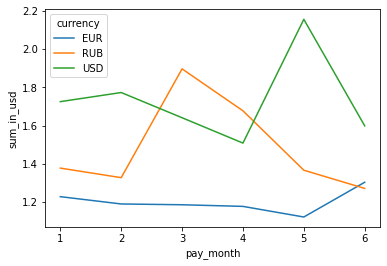

In [67]:
# revenue sum/month by currencies exchanged to USD
sns.lineplot(data=r, 
            x='pay_month',
            y='sum_in_usd', 
            hue='currency');

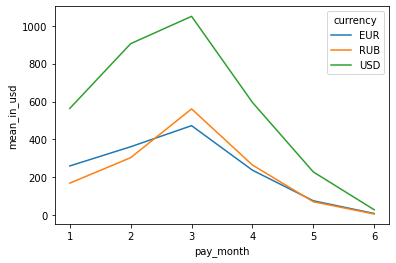

In [68]:
# revenue mean/month by currencies exchanged to USD
sns.lineplot(data=r, 
            x='pay_month',
            y='mean_in_usd', 
            hue='currency');

`Users amount`, `revenue sum` and `revenue mean` by currencies exchanged to USD and number of transactions per user.

In [69]:
z = revenue.groupby(['currency', 'id'])[
    ['currency', 'id', 'revenue_in_usd']].agg(
        {'id': 'count', 'revenue_in_usd': 'sum'}).rename(
            columns={'id': 'n_transactions'}).reset_index()

In [70]:
z.groupby(['currency', 'n_transactions'])[
    ['id', 'revenue_in_usd']].agg(
        {'id': 'count', 'revenue_in_usd': ['sum', 'mean']})

id revenue_in_usd          
                        count            sum      mean
currency n_transactions                               
EUR      1               1034    1232.336730  1.191815
         2                 73     159.734394  2.188142
         3                  4      25.907882  6.476970
RUB      1                783    1225.665906  1.565346
         2                 40     151.591039  3.789776
USD      1               1579    2662.147566  1.685971
         2                192     669.968278  3.489418
         3                 10      35.727671  3.572767
         4                  1       5.762698  5.762698

If we exchange all currencies to USD - the situation will not change.

The average transaction sum increase with the number of transaction. So, it makes sense to motivate users invest more in game, because the each next user's transaction is higher than previous (in average).

So, it's better to focus on US market and people paying in USD because of the higher revenue, and higher number of tranasctions.

### 4. Spends

In [71]:
print(spends['dt'].min(), spends['dt'].max(), sep='\n')

2018-01-01 00:00:00
2018-03-31 00:00:00


In [72]:
spends['spend_month'] = spends['dt'].dt.month

In [73]:
spends.head()

,dt,spends_usd,spend_month
0,2018-01-01,1687.170085,1
1,2018-01-02,1752.709034,1
2,2018-01-03,2081.399414,1
3,2018-01-04,1862.847898,1
4,2018-01-05,1920.828185,1


In [74]:
s = spends.groupby('spend_month')['spends_usd'].agg({'sum', 'mean', 'median'})

In [75]:
s

,median,mean,sum
spend_month,,,
1,1862.847898,1901.967746,58961.000131
2,1870.616531,1979.860771,55436.101591
3,1522.807990,1561.919071,48419.491190


### 5. Users + Revenue

Checking, if in the `revenue` table are some user `ids` who weren't in the `user` table - that means they had created account before the ad campaign started.

In [76]:
revenue.loc[~revenue.id.isin(users.id)]

,pay_dt,id,revenue,currency,pay_month,revenue_in_usd


In [77]:
temp = users.merge(revenue, 
                how='left', 
                left_on='id', 
                right_on='id').rename(columns={'dt': 'reg_dt'})

In [78]:
r = temp.groupby('id').agg({'reg_dt': 'min', 'pay_dt': 'min'})

In [79]:
r = r[~r['pay_dt'].isnull()]

In [80]:
r['delta'] = r['pay_dt'] - r['reg_dt']

In [81]:
r.head()

,reg_dt,pay_dt,delta
id,,,
41,2018-01-01,2018-02-19,49 days
43,2018-01-01,2018-01-06,5 days
49,2018-01-01,2018-01-19,18 days
88,2018-01-01,2018-01-03,2 days
112,2018-01-01,2018-01-06,5 days


In [82]:
# time from registration to the first transaction
print(f'Mean: {r.delta.mean()}\nMedian: {r.delta.median()}')

Mean: 21 days 06:31:59.550982226
Median: 14 days 00:00:00


If need, we can check time from registration to the second transaction. We just need to rank (1, 2, 3) transactions for each user on the previous step - before `merge`.

Also, need to mention that in `users` table we have data contains only 3 months. In the `revenue` table we have data contains 6 months.

### 6. Users + Spends

In [83]:
users['dt_month'] = users['dt'].dt.month

In [84]:
u = users.groupby('dt')['id'].count().to_frame().reset_index().rename(columns={'id': 'user_count'})

In [85]:
m = u.merge(spends, how='left', on='dt')

In [86]:
m['spend_day'] = m['dt'].dt.day

In [87]:
m.head()

,dt,user_count,spends_usd,spend_month,spend_day
0,2018-01-01,1871,1687.170085,1,1
1,2018-01-02,1645,1752.709034,1,2
2,2018-01-03,1814,2081.399414,1,3
3,2018-01-04,1824,1862.847898,1,4
4,2018-01-05,2273,1920.828185,1,5


We got the ad spends and the number of created accounts per each day.

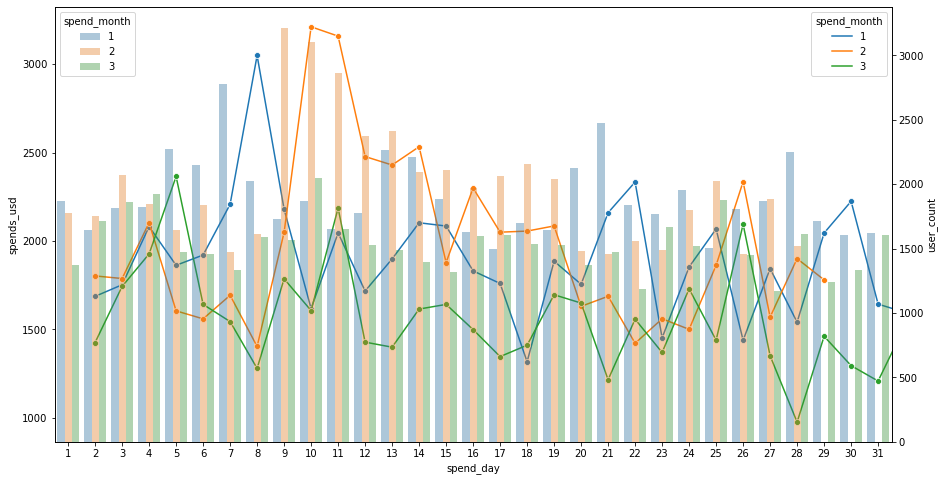

In [88]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(15,8))

# spends_usd
sns.lineplot(data = m, x='spend_day', y='spends_usd', hue='spend_month', 
             marker='o', sort = False, palette=['C0', 'C1', 'C2'], ax=ax1)

ax2 = ax1.twinx()

# user_count
sns.barplot(data = m, x='spend_day', y='user_count', hue='spend_month', alpha=0.4, ax=ax2);

In [89]:
m['cost_per_user'] = round(m['spends_usd'] / m['user_count'], 2)

In [90]:
m.head()

,dt,user_count,spends_usd,spend_month,spend_day,cost_per_user
0,2018-01-01,1871,1687.170085,1,1,0.90
1,2018-01-02,1645,1752.709034,1,2,1.07
2,2018-01-03,1814,2081.399414,1,3,1.15
3,2018-01-04,1824,1862.847898,1,4,1.02
4,2018-01-05,2273,1920.828185,1,5,0.85


### 7. Users + Spends + Revenue

In [91]:
r = revenue.groupby('pay_dt')['revenue_in_usd'].sum().reset_index()

In [92]:
r['pay_month'] = r['pay_dt'].dt.month
r['pay_day'] = r['pay_dt'].dt.day

In [93]:
r

,pay_dt,revenue_in_usd,pay_month,pay_day
0,2018-01-01,2.107607,1,1
1,2018-01-02,5.301488,1,2
2,2018-01-03,21.587329,1,3
3,2018-01-04,10.893795,1,4
4,2018-01-05,14.788244,1,5
...,...,...,...,...
164,2018-06-15,4.101767,6,15
165,2018-06-18,1.736037,6,18
166,2018-06-20,1.253464,6,20
167,2018-06-23,2.110436,6,23


In [94]:
temp = r.merge(m, how='left', left_on='pay_dt', right_on='dt')

In [95]:
temp.head()

,pay_dt,revenue_in_usd,pay_month,pay_day,dt,user_count,spends_usd,spend_month,spend_day,cost_per_user
0,2018-01-01,2.107607,1,1,2018-01-01,1871.0,1687.170085,1.0,1.0,0.90
1,2018-01-02,5.301488,1,2,2018-01-02,1645.0,1752.709034,1.0,2.0,1.07
2,2018-01-03,21.587329,1,3,2018-01-03,1814.0,2081.399414,1.0,3.0,1.15
3,2018-01-04,10.893795,1,4,2018-01-04,1824.0,1862.847898,1.0,4.0,1.02
4,2018-01-05,14.788244,1,5,2018-01-05,2273.0,1920.828185,1.0,5.0,0.85


In [96]:
t = temp.groupby('pay_month')[['user_count', 'cost_per_user', 
                        'spends_usd', 'revenue_in_usd']].agg({
    'user_count': 'sum', 
    'cost_per_user': 'mean',  
    'spends_usd': ['sum', 'mean'], 
    'revenue_in_usd': ['sum', 'mean']})

In [97]:
t['ratio'] = t['revenue_in_usd']['sum'] - t['spends_usd']['sum']

In [98]:
t['arpu'] = t['revenue_in_usd']['sum'] / t['user_count']['sum']

In [99]:
t

user_count cost_per_user    spends_usd              revenue_in_usd  \
                 sum          mean           sum         mean            sum   
pay_month                                                                      
1            58792.0      1.005806  58961.000131  1901.967746     993.890183   
2            55119.0      1.010714  55436.101591  1979.860771    1571.577614   
3            47524.0      1.017419  48419.491190  1561.919071    2084.719877   
4                0.0           NaN      0.000000          NaN    1098.541284   
5                0.0           NaN      0.000000          NaN     375.859305   
6                0.0           NaN      0.000000          NaN      44.253901   

                             ratio      arpu  
                mean                          
pay_month                                     
1          32.060974 -57967.109949  0.016905  
2          56.127772 -53864.523976  0.028512  
3          67.249028 -46334.771313  0.043867  
4          36.618043   1098.541284       inf  
5          12.124494    375.859305       inf  
6           2.458550     44.253901       inf

In general, it looks like that promotion campaign wasn't successful: spends are higher than revenue.
Even the last three months, when the ads were disabled, monthly revenue was lower than in the previous months when the ads were active.

It looks like for existing traffic amount campaign has a high cost per user.

**6 months ARPU & ARPPU**

In [100]:
print(f"ARPU: {round(revenue['revenue_in_usd'].sum()/users['id'].nunique(), 3)} USD")

ARPU: 0.038 USD


In [101]:
print(f"ARPPU: {round(revenue['revenue_in_usd'].sum()/revenue['id'].nunique(), 3)} USD")

ARPPU: 1.924 USD


### 8. Logins + Revenue

Number of logins per day.

In [102]:
logins.head()

,login_dt,id
0,2018-01-01,1
1,2018-01-01,2
2,2018-01-01,3
3,2018-01-01,4
4,2018-01-01,5


In [103]:
print(logins['login_dt'].min(), logins['login_dt'].max(), sep='\n')

2018-01-01 00:00:00
2018-06-29 00:00:00


In [104]:
l = logins.groupby('id')['login_dt'].count().sort_values(ascending=False)

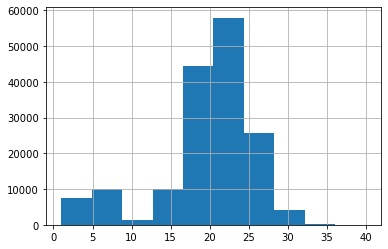

In [105]:
l.hist();

In [106]:
l = logins.groupby('login_dt')['id'].count().sort_values(
    ascending=False).reset_index().rename(
    columns={'id': 'n_logins'})

In [107]:
l

,login_dt,n_logins
0,2018-03-11,35313
1,2018-03-17,35188
2,2018-03-12,35185
3,2018-03-21,35075
4,2018-03-30,34943
...,...,...
175,2018-06-25,232
176,2018-06-26,191
177,2018-06-27,133
178,2018-06-28,90


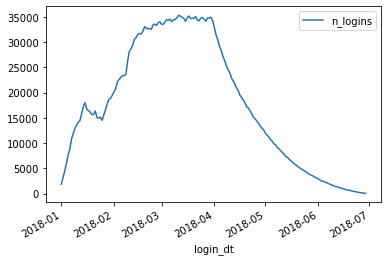

In [108]:
l.plot(x='login_dt', y='n_logins');

In [109]:
j = temp.merge(l, how='left', left_on='pay_dt', right_on='login_dt')

In [110]:
j

,pay_dt,revenue_in_usd,pay_month,pay_day,dt,user_count,spends_usd,spend_month,spend_day,cost_per_user,login_dt,n_logins
0,2018-01-01,2.107607,1,1,2018-01-01,1871.0,1687.170085,1.0,1.0,0.90,2018-01-01,1871
1,2018-01-02,5.301488,1,2,2018-01-02,1645.0,1752.709034,1.0,2.0,1.07,2018-01-02,3135
2,2018-01-03,21.587329,1,3,2018-01-03,1814.0,2081.399414,1.0,3.0,1.15,2018-01-03,4446
3,2018-01-04,10.893795,1,4,2018-01-04,1824.0,1862.847898,1.0,4.0,1.02,2018-01-04,5936
4,2018-01-05,14.788244,1,5,2018-01-05,2273.0,1920.828185,1.0,5.0,0.85,2018-01-05,7642
...,...,...,...,...,...,...,...,...,...,...,...,...
164,2018-06-15,4.101767,6,15,NaT,NaN,NaN,NaN,NaN,NaN,2018-06-15,1049
165,2018-06-18,1.736037,6,18,NaT,NaN,NaN,NaN,NaN,NaN,2018-06-18,731
166,2018-06-20,1.253464,6,20,NaT,NaN,NaN,NaN,NaN,NaN,2018-06-20,594
167,2018-06-23,2.110436,6,23,NaT,NaN,NaN,NaN,NaN,NaN,2018-06-23,372


In [111]:
j.corr()

,revenue_in_usd,pay_month,pay_day,user_count,spends_usd,spend_month,spend_day,cost_per_user,n_logins
revenue_in_usd,1.000000,-4.828900e-01,2.142839e-02,-0.125427,-0.076702,6.262525e-01,1.935200e-01,0.098018,0.846488
pay_month,-0.482890,1.000000e+00,-7.669768e-02,-0.392641,-0.348441,1.000000e+00,1.910774e-17,0.047388,-0.481060
pay_day,0.021428,-7.669768e-02,1.000000e+00,-0.234010,-0.251426,-3.275613e-17,1.000000e+00,-0.071159,0.044430
user_count,-0.125427,-3.926408e-01,-2.340100e-01,1.000000,0.897623,-3.926408e-01,-2.340100e-01,-0.110124,-0.301527
spends_usd,-0.076702,-3.484411e-01,-2.514255e-01,0.897623,1.000000,-3.484411e-01,-2.514255e-01,0.331602,-0.262013
spend_month,0.626252,1.000000e+00,-3.275613e-17,-0.392641,-0.348441,1.000000e+00,1.910774e-17,0.047388,0.893052
spend_day,0.193520,1.910774e-17,1.000000e+00,-0.234010,-0.251426,1.910774e-17,1.000000e+00,-0.071159,0.257157
cost_per_user,0.098018,4.738808e-02,-7.115882e-02,-0.110124,0.331602,4.738808e-02,-7.115882e-02,1.000000,0.052397
n_logins,0.846488,-4.810595e-01,4.442997e-02,-0.301527,-0.262013,8.930515e-01,2.571565e-01,0.052397,1.000000


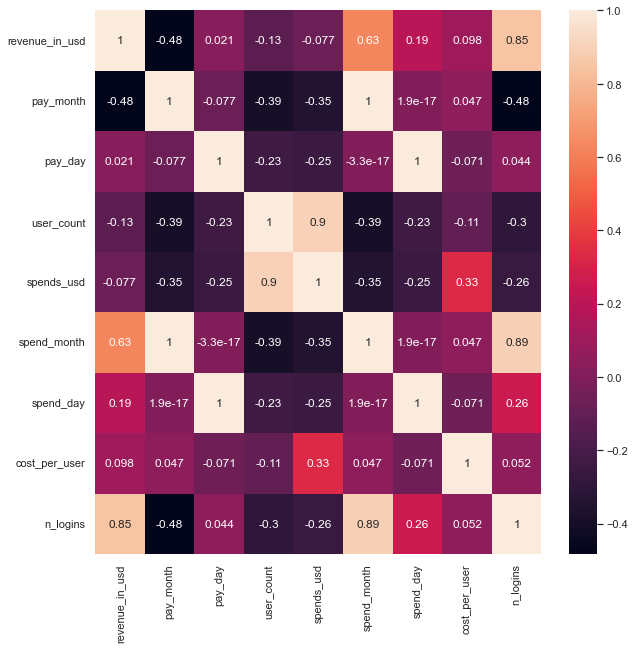

In [112]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.heatmap(j.corr(), annot=True);

Connection between the daily number of logins and revenue amount.

In [113]:
j.pivot_table(index=['pay_month', 'pay_day'], 
              values=['n_logins', 'revenue_in_usd'], 
              aggfunc='sum').sort_values(['revenue_in_usd', 'n_logins'], ascending=False)

n_logins  revenue_in_usd
pay_month pay_day                          
2         15          31524      107.185191
3         25          34886      106.691571
          4           34482      101.839046
          1           33545       96.990222
          9           34524       94.072066
...                     ...             ...
5         25           4262        0.633973
6         26            191        0.616869
          10           1591        0.512790
          11           1424        0.386407
5         28           3659        0.353869

[169 rows x 2 columns]

In [115]:
revenue

,pay_dt,id,revenue,currency,pay_month,revenue_in_usd
0,2018-01-01,186,64.910968,RUB,1,1.036916
1,2018-01-01,393,1.070690,USD,1,1.070690
2,2018-01-02,305,0.249002,EUR,1,0.207501
3,2018-01-02,358,0.314238,USD,1,0.314238
4,2018-01-02,2256,0.555161,USD,1,0.555161
...,...,...,...,...,...,...
4047,2018-06-20,149309,0.656961,USD,6,0.656961
4048,2018-06-20,153857,0.715804,EUR,6,0.596504
4049,2018-06-23,155881,1.789419,USD,6,1.789419
4050,2018-06-23,157399,0.385221,EUR,6,0.321018


Number of logins/each day per user.

In [289]:
x = logins.groupby(['id', 'login_dt'])['login_dt'].count().to_frame().rename(
    columns={'login_dt': 'n_logins'}).reset_index()

In [290]:
x.sort_values('n_logins', ascending=False)

,id,login_dt,n_logins
0,1,2018-01-01,1
2123215,112363,2018-04-12,1
2123193,112362,2018-03-29,1
2123194,112362,2018-04-22,1
2123195,112362,2018-04-28,1
...,...,...,...
1061603,63313,2018-02-10,1
1061604,63313,2018-02-11,1
1061605,63313,2018-02-14,1
1061606,63313,2018-02-21,1


Very strange. There is no one user with $>1$ login per day.

In [291]:
r = x.merge(revenue, how='left', left_on=['id', 'login_dt'], right_on=['id', 'pay_dt'])

In [292]:
r.head()

,id,login_dt,n_logins,pay_dt,revenue,currency,pay_month,revenue_in_usd
0,1,2018-01-01,1,NaT,NaN,NaN,NaN,NaN
1,1,2018-01-02,1,NaT,NaN,NaN,NaN,NaN
2,1,2018-01-03,1,NaT,NaN,NaN,NaN,NaN
3,1,2018-01-04,1,NaT,NaN,NaN,NaN,NaN
4,1,2018-01-05,1,NaT,NaN,NaN,NaN,NaN


In [293]:
r = r.groupby('id').agg({'n_logins': 'count', 
                         'revenue_in_usd': 'sum'}).sort_values(
                            ['revenue_in_usd'], ascending=False).reset_index()

In [294]:
r.head()

,id,n_logins,revenue_in_usd
0,139445,23,44.393400
1,61026,22,43.253018
2,42415,5,35.710251
3,142563,24,33.346365
4,151572,18,29.672764


In [295]:
r = r.pivot_table(index='n_logins', 
                  values=['revenue_in_usd', 'id'], 
                  aggfunc={'id': 'count', 
                           'revenue_in_usd': ['sum', 'mean']}).reset_index()

In [296]:
r.columns = r.columns.droplevel()

In [298]:
r.columns = ['n_logins', 'n_users', 'mean', 'sum']

In [299]:
r

,n_logins,n_users,mean,sum
0,1,237,0.011746,2.783859
1,2,1187,0.023014,27.317129
2,3,2522,0.035588,89.751679
3,4,3517,0.040342,141.882650
4,5,3701,0.041260,152.703860
5,6,3133,0.025479,79.825473
6,7,2108,0.024926,52.544187
7,8,1186,0.024697,29.291128
8,9,584,0.019197,11.211284
9,10,271,0.076238,20.660418


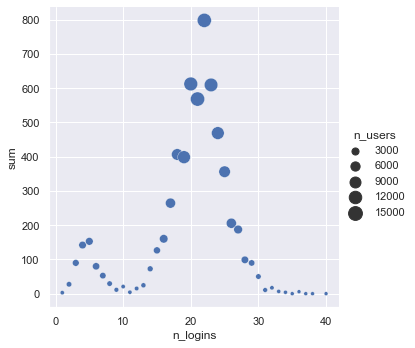

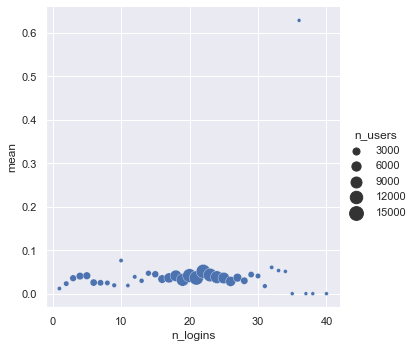

In [310]:
# sum
sns.relplot(data=r, 
            x='n_logins', y='sum', 
            size='n_users', 
            sizes=(15, 200))

# mean
sns.relplot(data=r, 
            x='n_logins', y='mean', 
            size='n_users', 
            sizes=(15, 200));

So, it looks like most hardcore users, which have the highest number of logins don't spend a lot of money. The highest spend has users who have 20-25 logins per tracked period.